# Sensor Data #

### Setup ###

In [1]:
# Import libraries
import numpy as np
import json as json
import pandas as pd
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import pylab as pl 
from zoneinfo import ZoneInfo
import imp

In [2]:
# Set options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
#this seems to fix the odd scrolling behavior when charts are present
%matplotlib inline 

In [3]:
# Chart parameters
Cw = 20
Ch = 5
Hs = 0.45
# Use dark Background
pl.style.use('dark_background')

In [4]:
# Timezone
My_timezone = "America/Los_Angeles"

### Functions ###

In [5]:
# import shared library
# imp reload is no longer necessary after changes to libs.py. Just re-execute this cell each time changes are made
imp.load_source('libs', '/home/mauro/sqrpi/lib/libs.py')
import libs as lb

### Load Settings ###

In [6]:
config=json.loads(open('settings.json','r').read())

In [7]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 
df = float(sample_rate)/float(n)

### User Input ###

Assign charts timescale 

In [21]:
Short_span = timedelta(hours=3)
Long_span =  timedelta(days=2)
# if using a different timezone
#Short_span = datetime.now(ZoneInfo(My_timezone)) - datetime.timedelta(hours=24)
#Long_span = datetime.now(ZoneInfo(My_timezone)) - datetime.timedelta(days=2)

## SenseHat Logs ##

In [9]:
# Read CSVs and refactor panda columns
# https://chatgpt.com/share/68c31a27-72e0-8006-87bf-5b7415782d79
logs = pd.read_csv('log_sec.csv', index_col = False)

#convert the utc timestamp to local time
logs["datetime"] = logs["timestamp"].apply(lambda ts: datetime.fromtimestamp(ts))
# if you need to convert it to another timezone
#logs["datetime_utc"] = pd.to_datetime(logs["timestamp"], unit="s", utc=True)
#logs["datetime"] = logs["datetime_utc"].dt.tz_convert(ZoneInfo(My_timezone))

logs['pressure'] = logs.pressure.astype(int)

logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
logs

,temperature,pressure,humidity,avg_pitch,avg_roll,max_pitch,max_roll,wave_height,dom_period,modal_period,avg_period,lat,lon,datetime
0,41,1021,57,1.2,3.1,-3.6,5.1,0.0,0.0,0.0,0.0,37.85967,-122.48193,2025-09-20 16:00:43.996
1,40,1021,58,1.4,3.0,-3.9,4.8,0.0,0.0,0.0,0.0,37.85963,-122.48193,2025-09-20 16:03:44.178
2,40,1021,59,1.4,3.0,-2.9,4.3,0.0,0.0,0.0,0.0,37.85963,-122.48190,2025-09-20 16:06:44.349
3,40,1021,59,1.5,2.9,-2.5,4.3,0.0,0.0,0.0,0.0,37.85962,-122.48192,2025-09-20 16:09:44.475
4,40,1021,59,1.5,2.9,-3.4,4.0,0.0,0.0,0.0,0.0,37.85963,-122.48192,2025-09-20 16:12:44.623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,42,1015,61,1.1,2.6,-4.0,4.5,0.0,0.0,0.0,0.0,0.00000,0.00000,2025-09-22 17:33:38.408
730,43,1015,61,1.2,2.5,4.6,4.3,0.0,0.0,0.0,0.0,0.00000,0.00000,2025-09-22 17:36:38.657
731,43,1015,60,1.2,2.4,3.4,4.7,0.0,0.0,0.0,0.0,0.00000,0.00000,2025-09-22 17:39:38.791
732,43,1015,60,1.0,2.4,-2.7,4.5,0.0,0.0,0.0,0.0,0.00000,0.00000,2025-09-22 17:42:38.929


In [10]:
# Reindex on datetime and aggregate by hour
logs.set_index('datetime', inplace=True)
hourly_logs = logs.resample('h').mean()
last_log = logs.index[-1]

In [11]:
# Filter on Datetime
logs = logs[logs.index > (last_log - Short_span)]
hourly_logs = hourly_logs[hourly_logs.index > (last_log - Long_span) ] 

<br><br>
Note: Change _Short_span_ and _Long_span_ constants under _User Input_ to adjust the chart timelines

### Wave Action ###
----

- __Significant Wave Height__: the average height of the highest one-third of the waves measured during the sampling period

- __Dominant Wave Period__: the period (=1/frequency), measured in seconds, that corresponds to the highest amount of wave energy in the wave spectrum. It represents the most energetic waves, indicating they are either swell (longer-period, more powerful waves from distant storms) or wind-waves (shorter-period waves generated by local winds). 

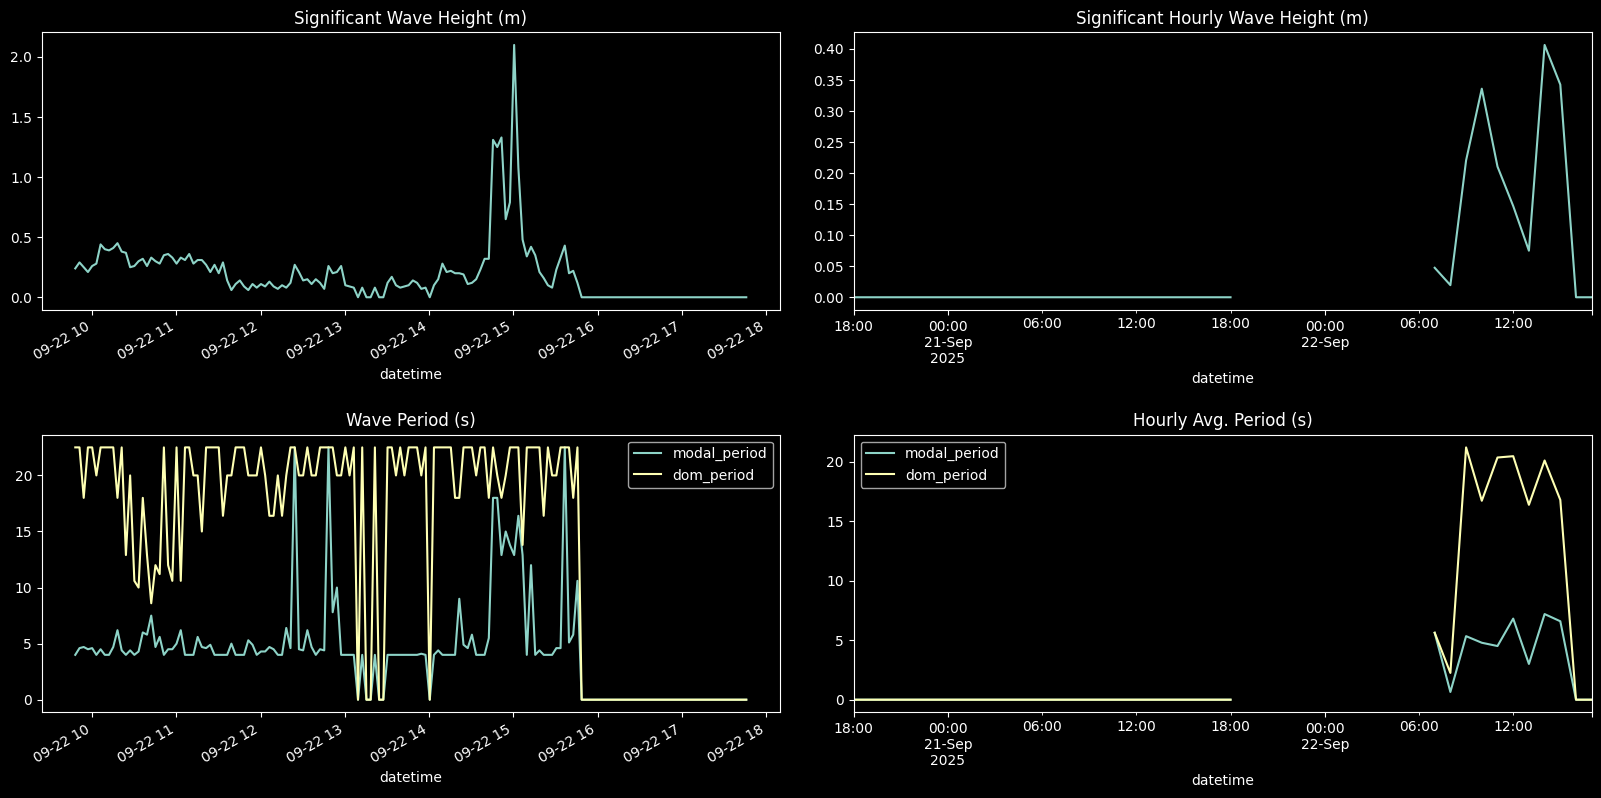

In [22]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

logs['wave_height'].plot( kind='line', ax=axes[0,0], title="Significant Wave Height (m)")
hourly_logs['wave_height'].plot( kind='line', ax=axes[0,1], title="Significant Hourly Wave Height (m)")

logs[['modal_period', 'dom_period']].plot( kind='line', ax=axes[1,0], title="Wave Period (s)")
hourly_logs[['modal_period', 'dom_period']].plot( kind='line', ax=axes[1,1], title="Hourly Avg. Period (s)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Pitch and Roll ###
----
- ___RMS of Pitch and Roll___:  Root Mean Square (RMS) of sampled pitch and roll angles, in degrees. 

- ___Maximum Pitch and Roll___:  maximum values recorded during the sampling period, relative to the beam and centerline vertical planes respectively, in degrees. A positive pitch is when the stern is higher than the bow, and a positive roll is when the starboard side is higher than the port side, assuming the SenseHat card is deployed with the led matrix forward.

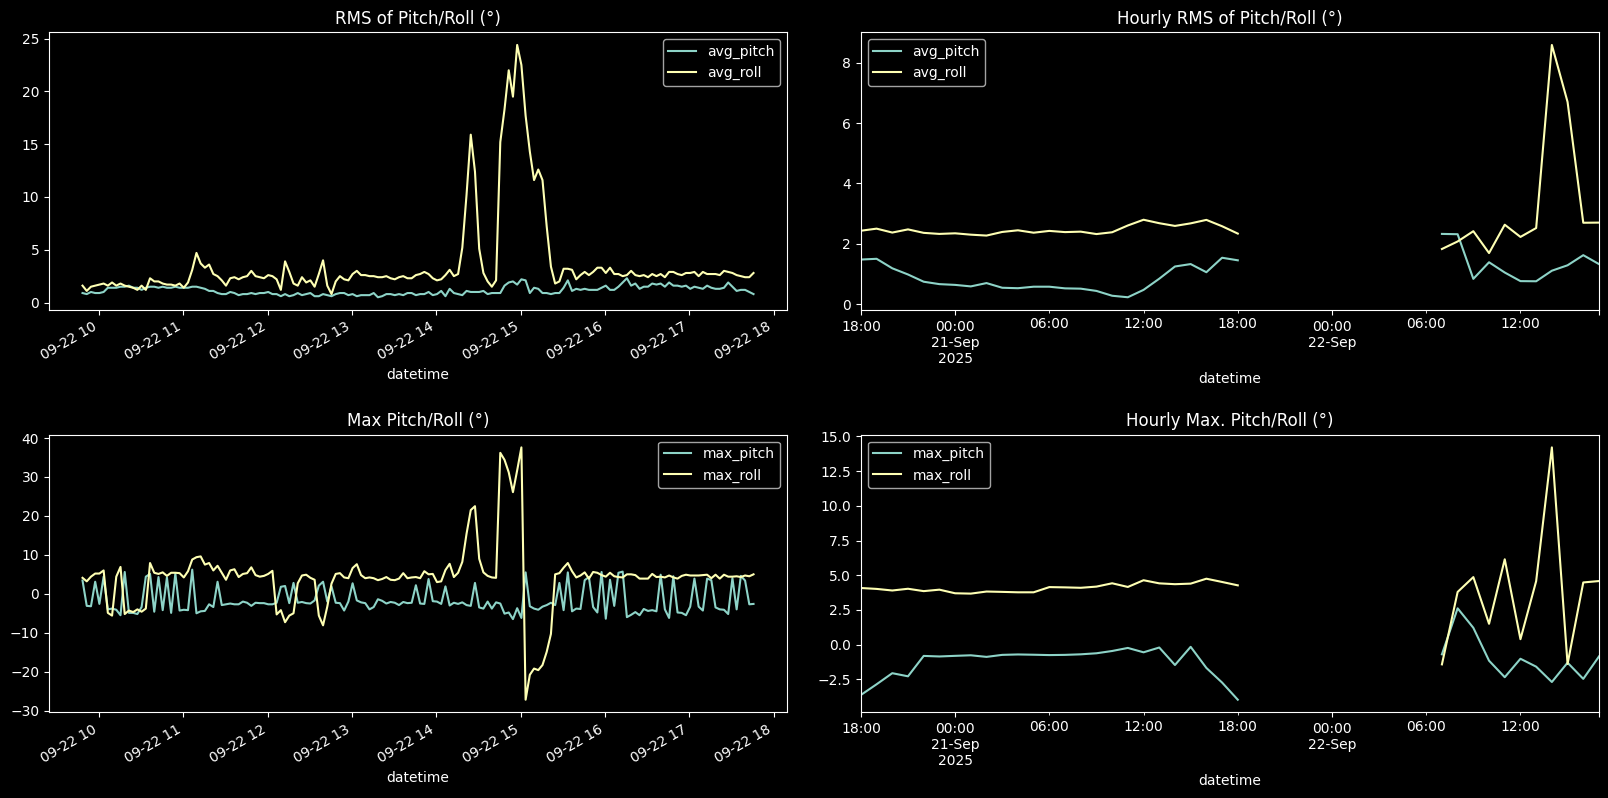

In [13]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

logs[['avg_pitch', 'avg_roll']].plot( kind='line', ax=axes[0,0], title="RMS of Pitch/Roll (°)")
hourly_logs[['avg_pitch', 'avg_roll']].plot( kind='line', ax=axes[0,1], title="Hourly RMS of Pitch/Roll (°)")

logs[['max_pitch', 'max_roll']].plot( kind='line', ax=axes[1,0], title="Max Pitch/Roll (°)")
hourly_logs[['max_pitch','max_roll']].plot( kind='line', ax=axes[1,1], title="Hourly Max. Pitch/Roll (°)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Environmental Variables ### 
----

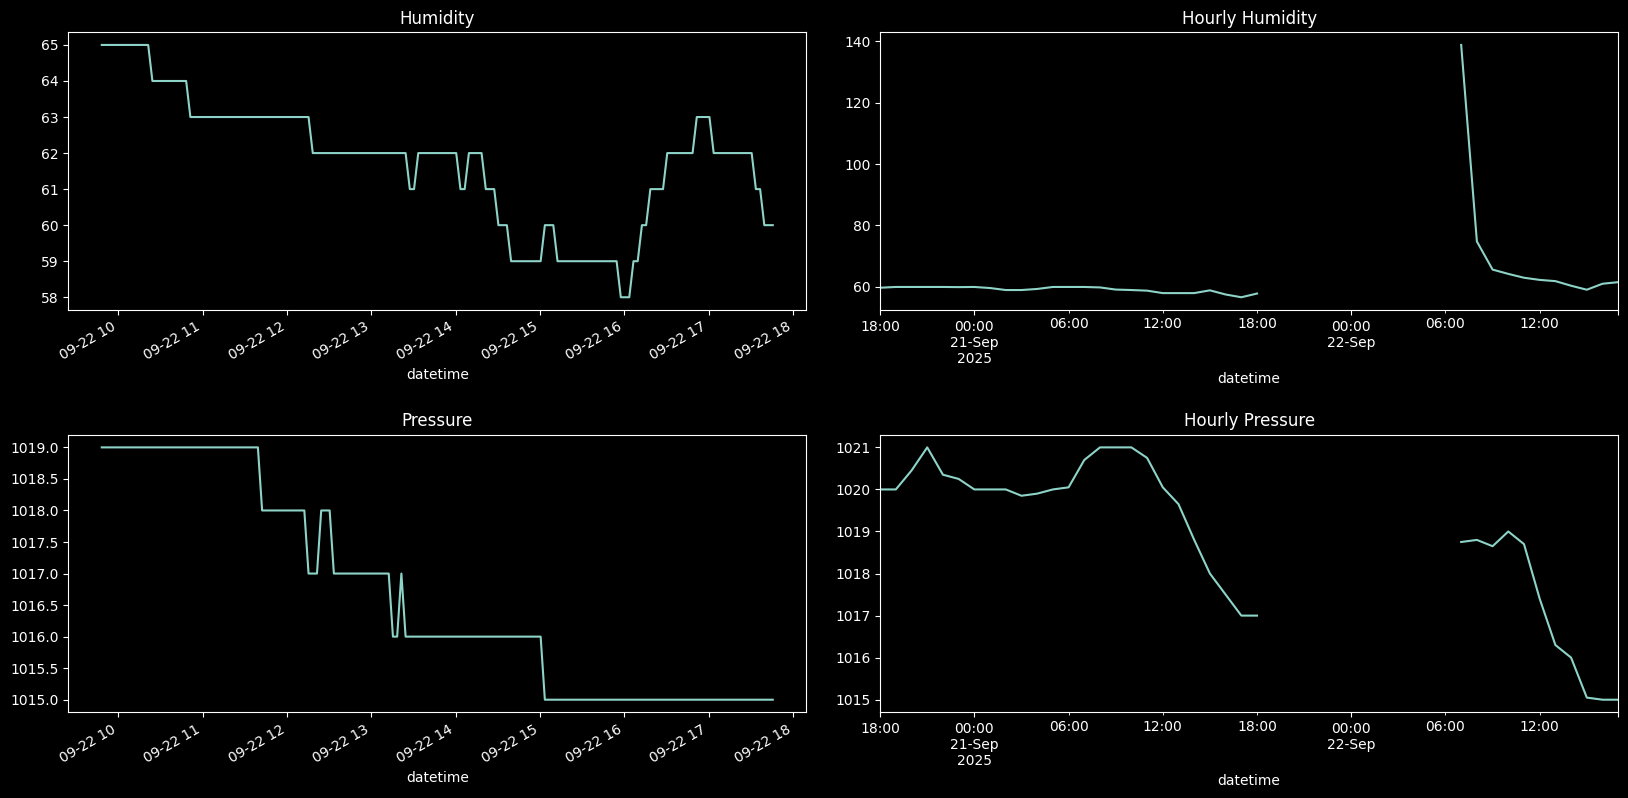

In [14]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

logs['humidity'].plot( kind='line', ax=axes[0,0], title="Humidity")
hourly_logs['humidity'].plot( kind='line', ax=axes[0,1], title="Hourly Humidity")

logs['pressure'].plot( kind='line', ax=axes[1,0], title="Pressure")
hourly_logs['pressure'].plot( kind='line', ax=axes[1,1], title="Hourly Pressure")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

<br>

## NMEA logs ##

In [15]:
# Read CSV and refactor columns
nm_logs = pd.read_csv('log_nmea.csv', index_col = False)
# convert unix timestamp to local day/time
nm_logs["datetime"] = nm_logs["timestamp"].apply(lambda ts: datetime.fromtimestamp(ts))
# if using another timezone
#nm_logs["datetime_utc"] = pd.to_datetime(nm_logs["timestamp"], unit="s", utc=True)
#nm_logs["datetime"] = nm_logs["datetime_utc"].dt.tz_convert(ZoneInfo(My_timezone))
nm_logs

,timestamp,lat,lon,sog_kts,cog,hdg,hdg_mag,hdg_true,wind_sp_kts,wind_angle,depth_ft,depth_m,water_temp_c,datetime
0,1.758409e+09,37.85967,-122.48183,0.000,106.0,116.0,116.0,116.0,14.73,109.0,9.05,2.76,13.0,2025-09-20 15:56:13.991
1,1.758409e+09,37.85970,-122.48195,0.000,6.0,115.0,115.0,115.0,13.86,110.0,8.98,2.74,13.0,2025-09-20 15:57:13.992
2,1.758409e+09,37.85967,-122.48193,0.000,6.0,115.0,115.0,115.0,16.38,110.0,9.32,2.84,0.0,2025-09-20 15:58:37.345
3,1.758409e+09,37.85973,-122.48195,0.000,10.0,116.0,116.0,116.0,16.56,106.0,9.18,2.80,0.0,2025-09-20 15:59:37.350
4,1.758409e+09,37.85967,-122.48193,0.000,2.0,116.0,116.0,116.0,16.69,107.0,10.13,3.09,0.0,2025-09-20 16:00:37.355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,1.758579e+09,37.84298,-122.42450,7.889,292.0,291.0,291.0,311.0,22.76,300.0,140.78,42.92,0.0,2025-09-22 15:04:37.953
701,1.758579e+09,37.84433,-122.42689,8.315,293.0,292.0,292.0,312.0,22.91,300.0,146.65,39.68,0.0,2025-09-22 15:05:37.985
702,1.758579e+09,37.84519,-122.42935,7.552,283.0,277.0,277.0,299.0,24.41,307.0,97.68,29.78,0.0,2025-09-22 15:06:38.172
703,1.758579e+09,37.84598,-122.43163,7.098,281.0,277.0,277.0,303.0,24.17,307.0,78.45,23.92,0.0,2025-09-22 15:07:38.273


In [16]:
# Index on datetime and aggregate by hour
nm_logs.set_index('datetime', inplace=True)
hourly_nm_logs = nm_logs.resample('h').mean()
last_nm_log = nm_logs.index[-1]

In [17]:
# Filter on Datetime
nm_logs = nm_logs[nm_logs.index >= (last_nm_log - Short_span)]
hourly_nm_logs = hourly_nm_logs[hourly_nm_logs.index >= (last_nm_log - Long_span) ]

### Wind ###
----

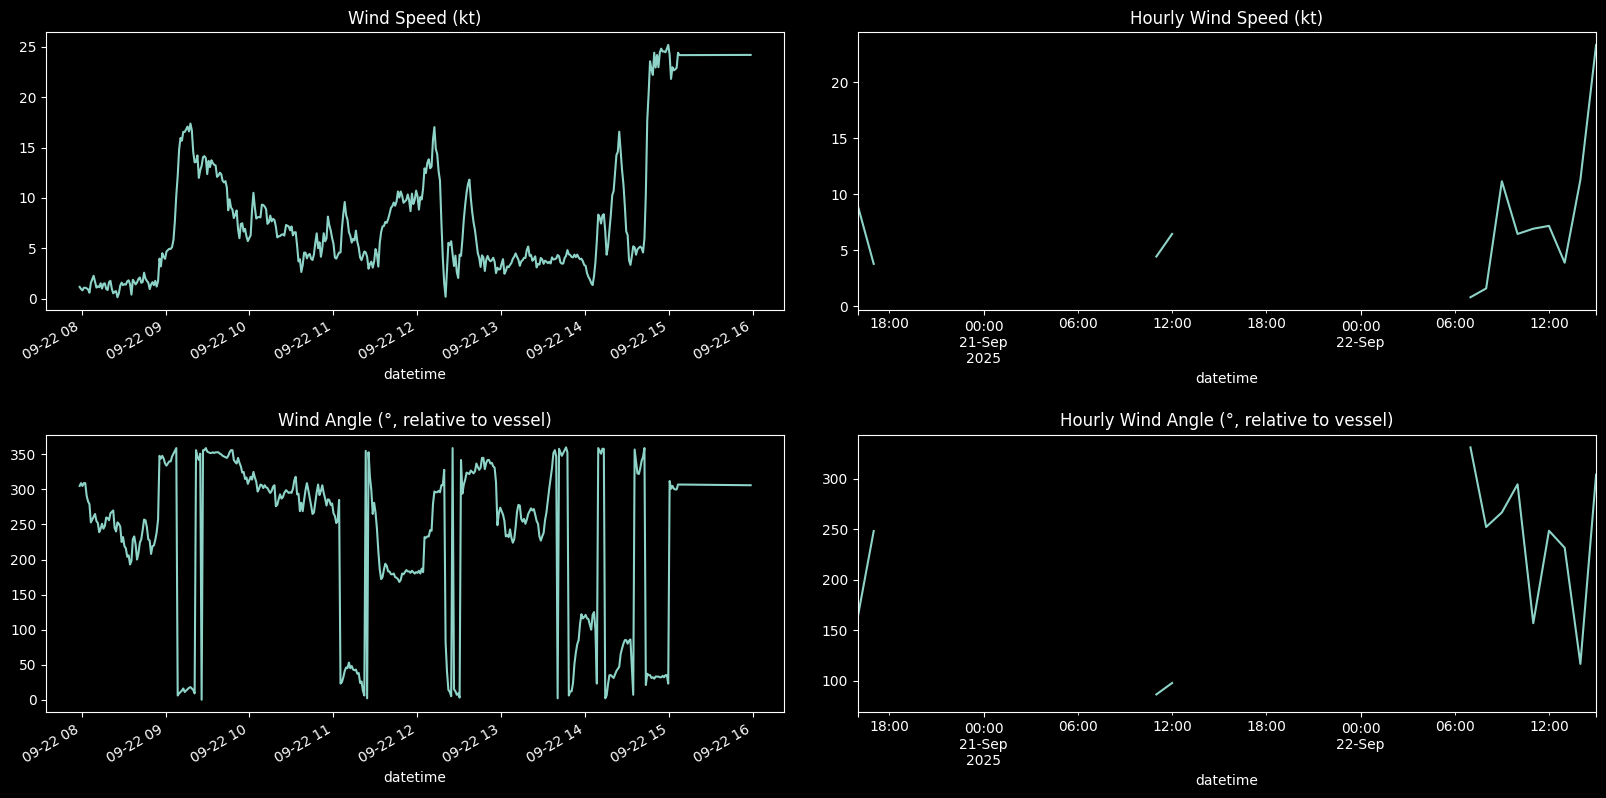

In [18]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

nm_logs['wind_sp_kts'].plot( kind='line', ax=axes[0,0], title="Wind Speed (kt)")
hourly_nm_logs['wind_sp_kts'].plot( kind='line', ax=axes[0,1], title="Hourly Wind Speed (kt)")

nm_logs['wind_angle'].plot( kind='line', ax=axes[1,0], title="Wind Angle (°, relative to vessel)")
hourly_nm_logs['wind_angle'].plot( kind='line', ax=axes[1,1], title="Hourly Wind Angle (°, relative to vessel)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Depth ###
----

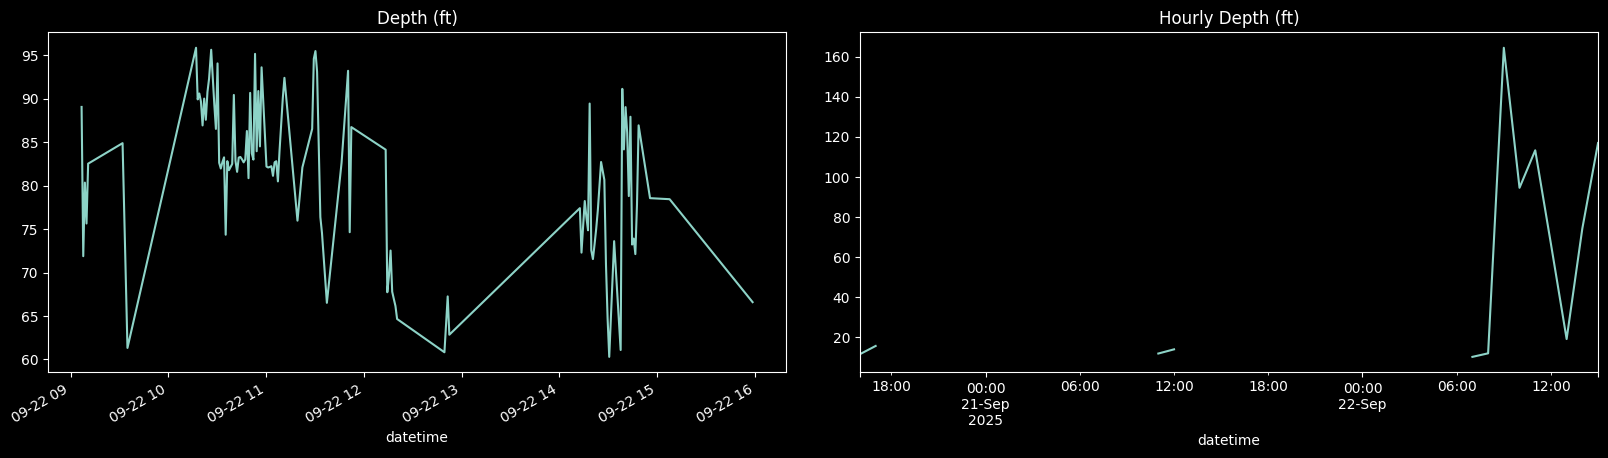

In [19]:
# Draw Charts
fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(Cw,Ch*1))

lb.remove_outliers(nm_logs['depth_ft'], sigma = .3).plot( kind='line', ax=axes[0], title="Depth (ft)")
hourly_nm_logs['depth_ft'].plot( kind='line', ax=axes[1], title="Hourly Depth (ft)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Speed, Course and Heading ###
----

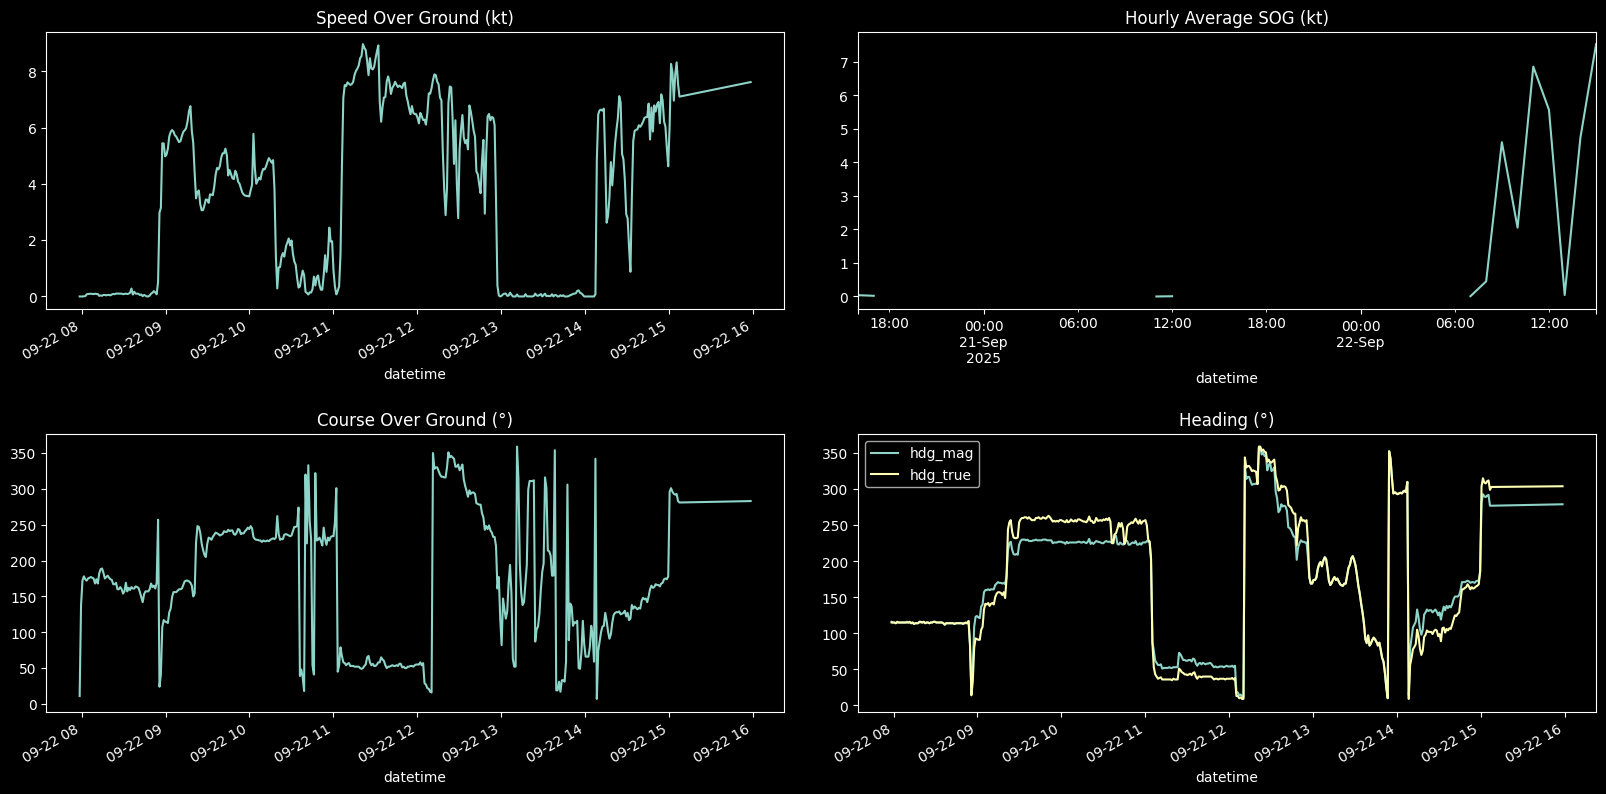

In [20]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

nm_logs['sog_kts'].plot( kind='line', ax=axes[0,0], title="Speed Over Ground (kt)")
hourly_nm_logs['sog_kts'].plot( kind='line', ax=axes[0,1], title="Hourly Average SOG (kt)")

nm_logs['cog'].plot( kind='line', ax=axes[1,0], title="Course Over Ground (°)")
nm_logs[['hdg_mag', 'hdg_true']].plot( kind='line', ax=axes[1,1], title="Heading (°)")
#nm_logs['hdg_true'].plot( kind='line', ax=axes[2,1], title="Magnetic True")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

End